# Put data set into Pandas dataframe

In [159]:
#import packages
import os
import glob 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [160]:
#initialize lists to transfer database into pandas dataframe
train_db = []
test_db = []
train_location = []
test_location = []

# Construct the database directory path
database_dir = os.path.join(os.getcwd(), 'CASIA Iris Image Database (version 1.0)')

#populate lists for dataframe
for i in range(1, 109, 1):
    person_index = '{:03}'.format(i)
    person_imgs = os.path.join(database_dir, person_index)
    train_dir = os.path.join(person_imgs, "1")
    test_dir = os.path.join(person_imgs, "2")

    train_list = glob.glob(os.path.join(train_dir, "*.bmp"))
    test_list = glob.glob(os.path.join(test_dir, "*.bmp"))

    train_location += train_list
    test_location += test_list

    for img_train in train_list:
        img_flat = cv2.imread(img_train, 0).ravel()
        train_db.append(img_flat)

    for img_test in test_list:
        img_flat = cv2.imread(img_test, 0).ravel()
        test_db.append(img_flat)

In [161]:
#create train and test dataframes
train = pd.DataFrame(train_db, columns=[i for i in range(280*320)]) # the image dimension is 280*320
test = pd.DataFrame(test_db, columns=[i for i in range(280*320)]) # the image dimension is 280*320

In [162]:
#create list of training images from the dataframe
train_lst = []
for i in range(train.shape[0]):
    im = train.iloc[i]
    image_data = im.values
    image = image_data.reshape((280, 320))
    train_lst.append(image)
    
#create list of testing images from the dataframe
test_lst = []
for i in range(test.shape[0]):
    im = test.iloc[i]
    image_data = im.values
    image = image_data.reshape((280, 320))
    test_lst.append(image)

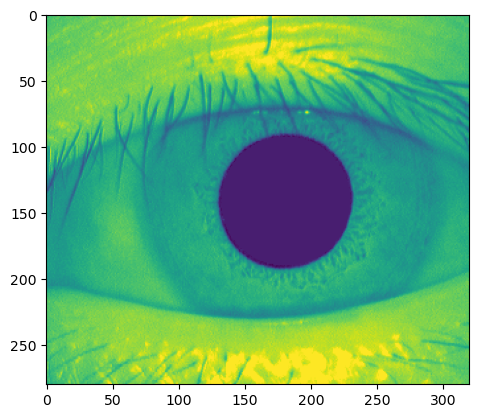

In [163]:
plt.imshow(train_lst[5])

# Iris Localization

In [164]:
def get_contours(img):
        image = img
        #threshold image to find contours
        ret, thresh = cv2.threshold(image, 65, 255, cv2.THRESH_BINARY)
        #find all contours
        contours,_ = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        image_copy = image.copy()
        cx = cy = 0
        xmin = xmax = ymin = ymax = 0
        #find our desired pupil contour
        for cnt in contours:
            if (cv2.contourArea(cnt) < 40000 and cv2.contourArea(cnt) > 700):
                cv2.drawContours(image=image_copy, contours=cnt, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
                M = cv2.moments(cnt)
                if M['m00'] != 0:
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])
                    xmin, ymin, xmax, ymax = cnt[0][0][0], cnt[0][0][1], cnt[0][0][0], cnt[0][0][1]
                    for point in cnt:
                        x, y = point[0]
                        xmin, ymin, xmax, ymax = min(xmin, x), min(ymin, y), max(xmax, x), max(ymax, y)

        #estimate pupil radius by takeing the average of min and max radius from center of contour
        pupil_r = (cy-ymin + cx-xmin + xmax-cx + ymax-cy)/4
        return cx, cy, pupil_r
    
def canny_circles(cx, cy, pupil_r, image):
    size=120
    pupil_c = cx, cy
    height, width = image.shape
    x_start = max(cx - size, 0)
    x_end = min(cx + size, width)
    y_start = max(cy - size, 0)
    y_end = min(cy + size, height)
    image_crop2 = image[y_start:y_end, x_start:x_end]
    image_crop3 = image_crop2.copy()
    
    cimg = cv2.cvtColor(image_crop2,cv2.COLOR_GRAY2BGR)
    k = 15
    blur = cv2.GaussianBlur(cimg,(k,k),0)
    canny = cv2.Canny(blur,15,5)
    canny[0:60]=0
    canny[50:190,50:190]=0
    
    circles = cv2.HoughCircles(
        canny,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=1000,
        param1=100,
        param2=12,
        minRadius=40,   # Rough estimate, may need to adjust
        maxRadius=125   # Rough estimate, may need to adjust
    )

    if circles is not None:
        # If circles are found, take the first one (you may need to change this logic)
        iris_r = circles[0, :][0][2]
        iris_x = circles[0, :][0][0]
        iris_y = circles[0, :][0][1]
        iris_c = (iris_x, iris_y)
        return pupil_c, iris_c, iris_r, image_crop2.shape
    else:
        # Handle the case where no circles are found
        print("No circles found.")
        # You can return None or some default values, or raise an exception
        return None, None, None, image_crop2.shape
    
#function to make circular masks isolating iris
def create_circular_mask(center, radius, shape):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

#function to apply masks and get iris region isolated
def get_iris_region(pupil_c, pupil_r, iris_r, image):
    pupil_mask = create_circular_mask(pupil_c, pupil_r, image.shape)
    iris_mask = create_circular_mask(pupil_c, iris_r, image.shape)

    # Subtract masks to get the iris region
    iris_only_mask = iris_mask.astype(np.uint8) - pupil_mask.astype(np.uint8)

    # Use the iris only mask to extract the iris region from the image
    iris_region = cv2.bitwise_and(image, image, mask=iris_only_mask.astype(np.uint8))
    return iris_region




def execute_iris_region(imlist):
    iris_list = []
    pupil_center_list = []
    for image in imlist:
        cx, cy, pupil_r = get_contours(image)
        results = canny_circles(cx, cy, pupil_r, image)
        
        # Check if canny_circles returned None values
        if results[0] is None or results[1] is None or results[2] is None:
            continue  # Skip the current image and continue with the next one

        pupil_c, iris_c, iris_r, shape = results
        #append pupil center to list for normalization part
        pupil_center_list.append(pupil_c)
        iris = get_iris_region(pupil_c, pupil_r, iris_r, image)
        iris_list.append(iris)
    return iris_list, pupil_center_list

In [165]:
train_iris_lst, train_pupil_c_lst = execute_iris_region(train_lst)
test_iris_lst, test_pupil_c_lst = execute_iris_region(test_lst)

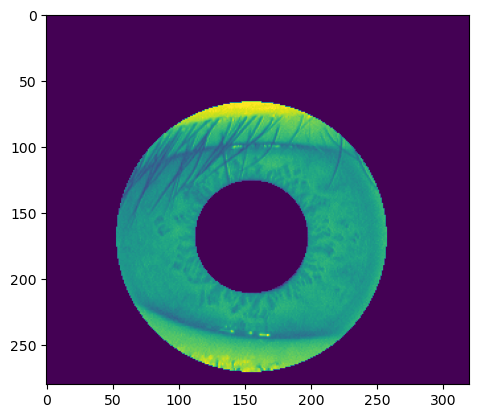

In [166]:
plt.imshow(train_iris_lst[296])

# Iris Normalization

In [167]:
def cartesian_to_polar(img, center):
    max_radius = int(np.linalg.norm(img.shape - np.array(center)))
    
    # Create an output image with the same width as the input image and height equal to the maximum radius
    polar_img = np.zeros((max_radius, img.shape[1], 3), dtype=np.uint8)
    
    for i in range(img.shape[1]):  # For each column in the input image
        for j in range(max_radius):  # For each row in the polar image
            theta = 2 * np.pi * i / img.shape[1]  # Calculate the angle
            r = j  # Radius is just the row index in the polar image
            x = center[0] + r * np.cos(theta)
            y = center[1] + r * np.sin(theta)
            
            if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                polar_img[j, i] = img[int(y), int(x)]
                
    return polar_img

def crop_black_region(image):
    # Find the rows where all values are not black
    rows = np.any(image != 0, axis=1)
    cols = np.any(image != 0, axis=0)
    
    # Find the bounds of the non-black region
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    # Slice and return the cropped region
    cropped_image = image[rmin:rmax+1, cmin:cmax+1]
    final_image = cv2.resize(cropped_image, (512,64))
    return final_image

def execute_normalization(img_lst, pupil_lst):
    normalization_lst = []
    for i in range(len(img_lst)):
        iris_region = img_lst[i]
        pupil_c = pupil_lst[i]
        polar_pic = cartesian_to_polar(iris_region, pupil_c)
        cropped_polar = crop_black_region(polar_pic)
        normalization_lst.append(cropped_polar)
    return normalization_lst

In [168]:
train_normalization_lst = execute_normalization(train_iris_lst, train_pupil_c_lst)
test_normalization_lst = execute_normalization(test_iris_lst, test_pupil_c_lst)

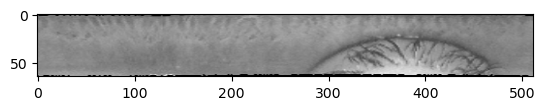

In [169]:
plt.imshow(train_normalization_lst[0])

# Iris Enhancement

In [170]:
def enhance_iris(image):
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Estimate Background Illumination
    block_size = 16
    background = cv2.resize(cv2.resize(image, (image.shape[1] // block_size, image.shape[0] // block_size)),
                            (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # Step 2: Lighting Correction
    corrected_image_float = np.float32(image) - np.float32(background)  # Use float for subtraction
    corrected_image = np.clip(corrected_image_float, 0, 255).astype('uint8')

    # Step 3: Local Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))
    enhanced_image = clahe.apply(corrected_image)
    ROI = enhanced_image[16:64, 0:512]
    return ROI

def execute_enhancement(im_lst):
    enhanced_lst = []
    for im in im_lst:
        enhanced = enhance_iris(im)
        enhanced_lst.append(enhanced)
    return enhanced_lst

In [171]:
train_ROI_lst = execute_enhancement(train_normalization_lst)
test_ROI_lst = execute_enhancement(test_normalization_lst)

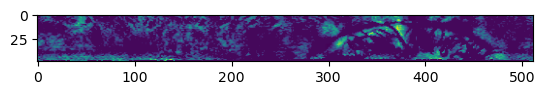

In [172]:
plt.imshow(train_ROI_lst[0])

# Feature Extraction

In [173]:
from scipy import signal

In [174]:
#takes in what channel and changes sigma values accordingly
def construct_kernel(channel):
    ksize = 3  # Size of the kernel (should be odd)
    kernel = np.zeros((ksize, ksize), dtype=np.float32)
    
    if channel == 1:
        sigma_x = 3
        sigma_y = 1.5
    if channel == 2:
        sigma_x = 4.5
        sigma_y = 1.5
    
    #loop through each kernel position and apply gabor filter
    for x in range(ksize):
        for y in range(ksize):
            x = x - ksize // 2
            y = y - ksize // 2
            #f should be 1 / dy, still a little confused on this part
            f = 1 / sigma_y
            
            #break down gabor filter equation
            gauss_coeff = (1 / (2 * np.pi * sigma_x * sigma_y))
            gauss = np.exp(-.5 * ((x**2/ sigma_x**2) + (y**2/ sigma_y**2)))
            m = np.cos(2 * np.pi * f * np.sqrt(x**2 + y**2))
            value = gauss_coeff * gauss * m
            #assign each place in kernel to new filtered value
            kernel[x, y] = value

    # Normalize the kernel
    kernel /= np.sum(np.abs(kernel))
    return kernel


def get_filtered_ims(im):
    #set kernels for each channel
    kernel1 = construct_kernel(1)
    kernel2 = construct_kernel(2)
    #apply each channel filter onto ROI
    fi1 = signal.convolve2d(im, kernel1, mode='same', boundary='wrap')
    fi2 = signal.convolve2d(im, kernel2, mode='same', boundary='wrap')
    #save in filtered images in list
    flist = [fi1, fi2]
    return flist


def get_feature_vector(im_list):
    feature_vec = []
    block_size = 8
    for im in im_list:
        width = im.shape[1]
        height = im.shape[0]
        for i in range(0, height, block_size):
            for j in range(0, width, block_size):
                block = im[i:i + block_size, j:j + block_size]
                m = np.mean(np.abs(block))
                sigma = np.std(block)
                feature_vec.append(m)
                feature_vec.append(sigma)
    return feature_vec

def execute_feature_vector(enhanced_lst):
    fc_lst = []
    for image in enhanced_lst:
        filtered_lst = get_filtered_ims(image)
        feature_vector = get_feature_vector(filtered_lst)
        fc_lst.append(feature_vector)
    return fc_lst

In [175]:
training_fc_lst = execute_feature_vector(train_ROI_lst)
testing_fc_lst = execute_feature_vector(test_ROI_lst)

# Iris Matching

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import NearestCentroid
import warnings
warnings.filterwarnings("ignore")

In [3]:
def nearest_centroid_classifier(train_samples, test_samples, lda=None):
    ## get the L1, L2, COS distance between f and fis
    def get_distance_matrix(test_sample, centroids):
        distance_matrix = np.zeros((centroids.shape[0], 3))

        for i in range(centroids.shape[0]):
            centroid = centroids[i].reshape(centroids.shape[1], 1)
            d1 = abs(test_sample - centroid).sum()
            d2 = np.sum((test_sample - centroid) * (test_sample - centroid))
            d3 = 1 - (test_sample.T.dot(centroid) / (np.linalg.norm(test_sample) * np.linalg.norm(centroid)))
            distance_matrix[i, 0] = d1
            distance_matrix[i, 1] = d2
            distance_matrix[i, 2] = d3

        return distance_matrix

    test_samples_transformed = test_samples

    
    if lda is not None:
        test_samples_transformed = lda.transform(test_samples_transformed)
        centroids = lda.transform(centroids)

    predictions = []
    distance_values = []

    for i in range(test_samples_transformed.shape[0]):
        test_sample = test_samples_transformed[i, :].reshape(test_samples_transformed.shape[1], 1)
        distance_matrix = get_distance_matrix(test_sample, centroids)
        min_distance_index = np.argmin(distance_matrix, axis=0)
        prediction = min_distance_index + 1

        values = []
        value_matrix = distance_matrix[min_distance_index]
        values.append(value_matrix[0][0])
        values.append(value_matrix[1][1])
        values.append(value_matrix[2][2])

        predictions.append(prediction)
        distance_values.append(values)

    return (distance_values, predictions)


In [4]:
def evaluate(predictions, true_labels):
    correct_classifications = np.zeros(3)
    
    for i in range(len(true_labels)):
        prediction = predictions[i]
        if prediction[0] == true_labels[i]:
            correct_classifications[0] += 1
        if prediction[1] == true_labels[i]:
            correct_classifications[1] += 1
        if prediction[2] == true_labels[i]:
            correct_classifications[2] += 1

    return correct_classifications / len(true_labels)

# Prepare train and test data

In [5]:
#training_fc_lst is a list with 324 1d list entries each 1d list entry has length of 1536
#testing_fc_lst is a list with 432 1d list entries each 1d list entry has length of 1536
train_X = np.array(training_fc_lst)
train_Y = np.array([(i//3+1) for i in range(train_X.shape[0])])
test_X = np.array(testing_fc_lst)
test_Y = np.array([(i//4+1) for i in range(test_X.shape[0])])

# LDA Prediction

In [6]:
values_Org, predictions_Org = nearest_centroid_classifier(train_X, test_X, lda=None)

In [7]:
lda_org = LDA().fit(train_X, train_Y)   # the following section will tell us this LDA is the best
values_LDA, predictions_LDA = nearest_centroid_classifier(train_X, test_X, lda=lda_org)

# CRR Table

In [8]:
from prettytable import PrettyTable
def plot_CRR(originals, transforms1):
    ## convert the input data to 100% scale
    originals = originals*100
    transforms1 = transforms1*100
    
    ## construct the table
    table = PrettyTable()
    table.field_names = ["Similarity Measurement", "Original feature Set", "Reduced feature set (LDA)"]
    table.add_row(["L1 distance measure",originals[0],transforms1[0]])
    table.add_row(["L2 distance measure", originals[1], transforms1[1]])
    table.add_row(["Cosine similarity measure", originals[2], transforms1[2]])
    print("TABLE of Correct Recognition Rate (%) Using Different Similarity Measures")
    print(table)

In [185]:
originals = evaluate(predictions_Org, test_Y)
transforms1 = evaluate(predictions_LDA, test_Y)
plot_CRR(originals, transforms1)

TABLE of Correct Recognition Rate (%) Using Different Similarity Measures
+---------------------------+----------------------+---------------------------+
|   Similarity Measurement  | Original feature Set | Reduced feature set (LDA) |
+---------------------------+----------------------+---------------------------+
|    L1 distance measure    |  62.731481481481474  |     62.268518518518526    |
|    L2 distance measure    |  54.166666666666664  |     65.27777777777779     |
| Cosine similarity measure |  54.629629629629626  |     71.29629629629629     |
+---------------------------+----------------------+---------------------------+


# ROC Curve

In [186]:
def plot_LDA_tunning(tunning_values, rates):
    fg = plt.figure(figsize=(5, 5))
    ax = fg.add_subplot(111)

    ax.set_xlabel("Dimensionality of the feature vector", size="large")
    ax.set_ylabel("Correct regonition rate", size="large")

    line_cv = ax.plot(tunning_values, rates, label="recognition rate", marker='o')

    ax.legend(loc="best", fontsize="large")
    plt.show()

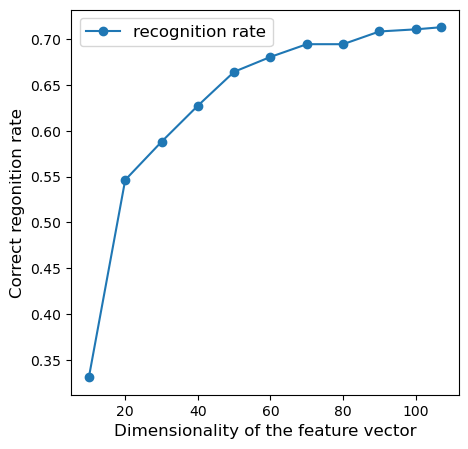

In [187]:
n_arr = [i for i in range(10, 108, 10)]+[107]
recognition_rates = np.empty(len(n_arr))
for i in range(len(n_arr)):
    lda = LDA(n_components=n_arr[i])
    lda.fit(train_X, train_Y) 
    max_recognition_rate = np.amax(evaluate(nearest_centroid_classifier(train_X, test_X, lda=lda)[1], test_Y))
    recognition_rates[i] = max_recognition_rate

plot_LDA_tunning(n_arr, recognition_rates)